In [2]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import libactive; reload(libactive)
import matplotlib.pyplot as plt
import math

In [3]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [4]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=1)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-42c7ef92-f304-4209-9c54-26280827d878.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
reload(libstop); from libstop import *
def acc_wrapper(**kwargs):
    x, diffs = first_acc(**kwargs)
    return [np.nan] +diffs
metrics = ['uncertainty_variance', 'uncertainty_variance_selected', 'uncertainty_average', 
           "n_support", "entropy_max", "expected_error_min", kappa_metric, acc_wrapper, SSNCut_values, fscore] # 
names = ['Uncertainty Variance', 'Queried Uncertainty Variance', 'Mean Uncertainty', '# support vectors', 'Max entropy', 'Min Expected Error', 'Kappa Agreement', 'First Accuracy', 'Clustering Agreement', 'Estimated F-score']

metrics = [lambda *args, **kwargs: list(fscore(*args, **kwargs))] # 
names = ['Estimated F-score']

[[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 0.66666667 0.

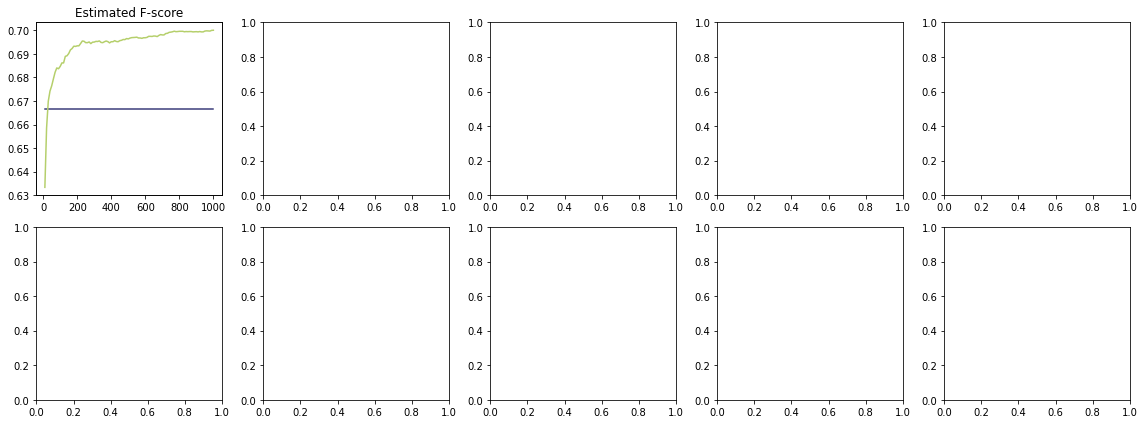

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(16,6))
results = results_plots[0][1]
conf = results_plots[0][0]
cm = plt.cm.get_cmap('tab20b')
for j, (metric, ax, name) in enumerate(zip(metrics, axes.flatten(), names)):
    # Get unlabelled pool
    X, y = getattr(libdatasets, conf.dataset_name)(None)
    unlabelled_pools = []
    y_oracles = []
    # WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
    for i in range(len(results)):
        _, X_unlabelled, _, Y_oracle, _, _ = active_split(
            X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
        )
        unlabelled_pools.append(X_unlabelled)
        y_oracles.append(Y_oracle)
    
    if isinstance(metric, str):
        values = np.array([results[i][metric] for i in range(len(results))])
        ax.set_title(name)
    else:
        values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])
        print(values)
        ax.set_title(name)
    ax.plot(results[0].x, np.mean(values, axis=0), label='Metric', color=cm.colors[0])
    ax2 = ax.twinx()
    ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), label='Accuracy', color=cm.colors[6])
    ax2.set_ylabel('Accuracy')
    
    if j != 4 and j != 9:
        ax2.axes.get_yaxis().set_visible(False)
    
    if j > 4:
        ax.set_xlabel("Instances")
fig.tight_layout()

In [52]:
fig.savefig('figures/metrics_comparison.png')

In [10]:
np.isin(10, [0,1,2,10])

array(True)

In [23]:
mask = np.ones(5, dtype=bool)

In [31]:
np.array([1,2,3,4,5])[[[2]]]==np.array([1,2,3,4,5])[[2]]

<ipython-input-31-5d9c77e28f8f>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.array([1,2,3,4,5])[[[2]]]==np.array([1,2,3,4,5])[[2]]


array([ True])